In [72]:
import torch
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import datasets
from typing import Any

In [5]:
# np.arange(5)
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [9]:
a = dir(datasets)

for text in a:
    if "mnist" in text.lower():
        print(text)

EMNIST
FashionMNIST
KMNIST
MNIST
MovingMNIST
QMNIST
mnist
moving_mnist


In [79]:
ROOT_DIR = "./dataset/"
SPLIT_DATA_BY = "bymerge"  # merges letters that have similar upper and lower cases, like C vs c and O vs o. 

def TRANSFORM_CALLABLE(img: Image.Image) -> Any:
    return img.transpose(Image.TRANSPOSE)


training_data = datasets.EMNIST(root=ROOT_DIR, split=SPLIT_DATA_BY, train=True, download=True, transform=TRANSFORM_CALLABLE)
test_data = datasets.EMNIST(ROOT_DIR, split=SPLIT_DATA_BY, train=False, download=True, transform=TRANSFORM_CALLABLE)

print(training_data)
print(test_data)

Dataset EMNIST
    Number of datapoints: 697932
    Root location: ./dataset/
    Split: Train
    StandardTransform
Transform: <function TRANSFORM_CALLABLE at 0x7f83c5418670>
Dataset EMNIST
    Number of datapoints: 116323
    Root location: ./dataset/
    Split: Test
    StandardTransform
Transform: <function TRANSFORM_CALLABLE at 0x7f83c5418670>


<class 'PIL.Image.Image'>


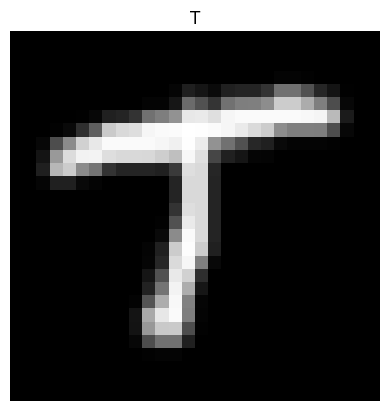

<class 'PIL.Image.Image'>


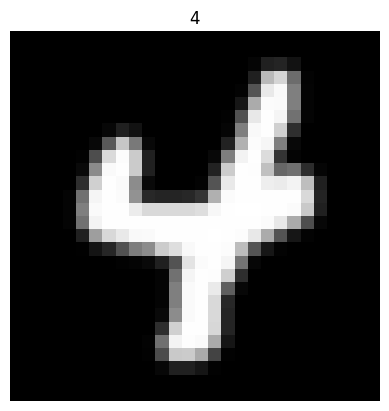

<class 'PIL.Image.Image'>


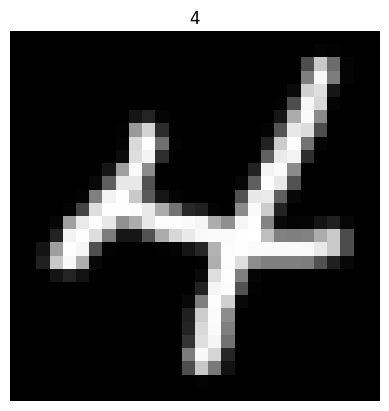

In [80]:
for i in range(3):
    rand_ind = torch.randint(len(training_data), size=(1,)).item()
    assert isinstance(rand_ind, int)

    img, label = training_data[rand_ind]
    img_class = training_data.classes[label]
    print(type(img))

    plt.imshow(img, cmap="gray")
    plt.title(img_class)
    plt.axis("off")
    plt.show()
